In [51]:
from __future__ import print_function, division
import os
import sys
import time 

import emcee
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pickle
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter('ignore', np.RankWarning)


from toggle_equations import *
from attractor_stats import *
from steady_states import *
from sim_funcs import *
from plotting_funcs import *


# Importing data to initialise run

`mcmc_initialise.csv`: Excel file that contains the normalised values of Sox2, Tbxta and TCF_mRNA of an 18ss TCF-GFP tailbud. 

Filename of sample: TCF-GFP_18ss_B1tbxta594_B4sox2647_B2egfp546_4_Series009.ims

NMp number = 182

In [52]:
##### df = pd.read_csv("normalised_exp.csv")
df = pd.read_csv("files/csv/mcmc_initialise.csv")
data = np.load("files/npy/loess_fit_vals_050421.npy")
#filt = (df["stage"] == "18ss") & (df["ID"] == 7)
nmp_numbers = len(df)
"""
groups = df.loc[filt, ].groupby("ID")
for _ , group in groups:
    nmp_list = group[["sox2_norm", "tbxta_norm", "tcf_norm"]].values.tolist()
"""

nmp_list = df[['sox2_norm', 'tbxta_norm']].values.tolist()
nmp_list_tcf = df[['sox2_norm', 'tbxta_norm','tcf_norm', 'TCF_group']].values.tolist()

In [53]:
mylist = [l for l in nmp_list_tcf if l[3] == 1]
len(mylist)

122

In [5]:
nmp_list_tcf

[[0.360546782606608, 0.33999913174345897, 0.49255643564356394, 1.0],
 [0.136614642376552, 0.142272516786293, 0.44234851485148496, 1.0],
 [0.0022842615479472398, 0.289887705487381, 0.361341584158416, 1.0],
 [0.0167444172357735, 0.13319923593424401, 0.305214356435644, 1.0],
 [0.0892862232725647, 0.18254514934012497, 0.29348861386138597, 1.0],
 [0.0484215442668186, 0.0673694721000232, 0.420704455445545, 1.0],
 [0.20611309994994398, 0.21186183144246398, 0.534039603960396, 1.0],
 [0.0201958124205222, 0.127264702477425, 0.585712871287129, 1.0],
 [0.0282417336785062, 0.20639326232924302, 0.551816831683168, 1.0],
 [0.0287867960881521, 0.21359689742996105, 0.42941386138613896, 1.0],
 [0.0152667480426509, 0.28986744616809396, 0.40976435643564396, 1.0],
 [0.0965945600771289, 0.134669483676777, 0.286610891089109, 0.0],
 [0.0953894220888292, 0.0411481245658717, 0.237076237623762, 0.0],
 [0.121361895937085, 0.094022053716138, 0.358061881188119, 0.0],
 [0.13895341016546398, 0.347962491317435, 0.24055

(array([26., 40., 37., 24., 18., 16., 11.,  6.,  1.,  3.]),
 array([0.12108168, 0.18168193, 0.24228218, 0.30288243, 0.36348267,
        0.42408292, 0.48468317, 0.54528342, 0.60588366, 0.66648391,
        0.72708416]),
 <a list of 10 Patch objects>)

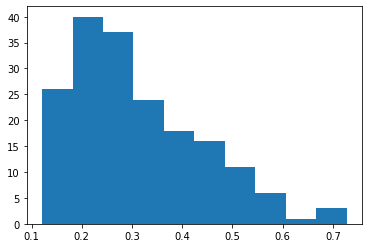

In [6]:
plt.hist(df.tcf_norm)

# Defining parameters

In [7]:
num_ss = 100
dt = .1  # Time step.
T = 10  # Total time.
tolerance = 1e-8
max1 = 1
max2 = 1
n = int(T / dt)
t = np.linspace(0., T, n)  # Vector of times.
sim_stages = np.linspace(0,n-1,num_ss, dtype = int)


## Curve for decreasing Wnt group

Text(0, 0.5, '$TCF\\;levels\\;/\\; \\alpha_{1} $')

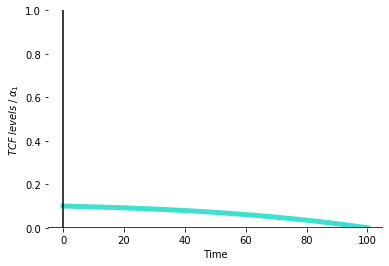

In [65]:
tcf_init = 0.1
x_vals = [0, n]
y_vals = [tcf_init, 0]
coefs = np.polyfit(x_vals,y_vals,3)
xf=np.linspace(0,n,n)
alpha_vals = np.polyval(coefs, xf)
plt.plot(xf, alpha_vals, linewidth=5, color = "turquoise")
plt.ylim([0, 1])
plt.box(False)
plt.axhline(0,color='k') # x = 0
plt.axvline(0,color='k') # y = 0
plt.xlabel("Time")
plt.ylabel(r"$TCF\;levels\;/\; \alpha_{1} $")

## Curve for increasing Wnt group

Text(0, 0.5, '$TCF\\;levels\\;/\\; \\alpha_{1} $')

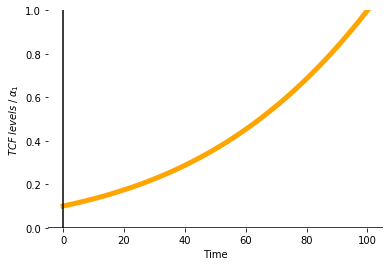

In [66]:
tcf_init = 0.1
x_vals = [0, n]
y_vals = [tcf_init, 1]
coefs = np.polyfit(x_vals,y_vals,3)
xf=np.linspace(0,n,n)
alpha_vals = np.polyval(coefs, xf)
plt.plot(xf, alpha_vals, linewidth=5, color = "orange")
plt.ylim([0, 1])
plt.box(False)
plt.axhline(0,color='k') # x = 0
plt.axvline(0,color='k') # y = 0
plt.xlabel("Time")
plt.ylabel(r"$TCF\;levels\;/\; \alpha_{1} $")

# Stoch model

`batch`: Total number of rounds to iterate the entire run. Equivalent to an entire HCR time-course experiment from 18ss to 28ss.

`num_nmps_time`: Number of NMps / nmp_numbers (total number of cells / embryo) / batch calculated at `num_ss` intervals.

`num_nmps_embryos_time`: `num_nmps_time` of all embryos

`batch_nmp_num`: `num_nmps_embryos_time` for all batches.


Non-autonomous TCF

In [7]:
def stoch_model_tcf(alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val):
    batch_num = 0
    batch = 1
    batch_nmp_num = [[] for i in range(batch)]

    while batch_num < batch:
        trajs_list = []
        i = 0
        while i < nmp_numbers:
            xinit = nmp_list_tcf[i][0]
            yinit = nmp_list_tcf[i][1]
            tcf_init = nmp_list_tcf[i][2]
            tcf_group = nmp_list_tcf[i][3]
            single_cell_sim = em_cle_tcf_alpha1(1, xinit, yinit, tolerance, dt , T, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, tcf_init = tcf_init, tcf_group = tcf_group, seed = batch_num)
            trajs_list.append(single_cell_sim)
            i+=1
        #print("Embryo simulation complete: {} cells".format(nmp_numbers))

        num_nmps_time = []
        for i in range(num_ss) :
            nmp_counter = 0
            traj = np.squeeze(np.array(trajs_list))[:,:,sim_stages[i]]
            for cell in traj:
                if not ((cell[0] <= exit_nmp_val and cell[1] >= exit_nmp_val) or (cell[0] >= exit_nmp_val and cell[1] <= exit_nmp_val)):
                    nmp_counter += 1
            num_nmps_time.append(nmp_counter)
        #print("num_nmps_time", num_nmps_time)
        batch_nmp_num[batch_num].append(num_nmps_time)
        batch_num +=1
    return batch_nmp_num



In [8]:
def em_cle_tcf_alpha1_test (n_traj, x_init, y_init, tolerance, dt , T, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, tcf_init, tcf_group, seed = 20):
    np.random.seed(seed)
    n = int(T / dt)
    t = np.linspace(0., T, n)
    sqrtdt =  np.sqrt(dt/omega) 
    x = np.zeros((n_traj,2,n))
    x[:,:,0]= [x_init,y_init]
    
    # Euler-Marayama method
    for k in range(n_traj):
        if (tcf_group == 0):
            x_vals = [0, n]
            y_vals = [tcf_init, 0]
            coefs = np.polyfit(x_vals,y_vals,3)
            xf=np.linspace(0,n,n)
            alpha_vals = np.polyval(coefs, xf)
            plt.plot(xf, alpha_vals)
            
            for i in range(n - 1):
                pp = protein_production([x[k][0][i], x[k][1][i]],alpha_vals[i],alpha2,a,c,b,d, max1, max2)
                print("alpha1_val - group 0", alpha_vals[i])
                de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
                detT = deterministic_term(pp,de)
                stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
                x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
                x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

                # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
                if(x[k][0][i + 1] < tolerance):
                    x[k][0][i + 1] = 0
                elif(x[k][1][i + 1] < tolerance):
                    x[k][1][i + 1] = 0
                    
        elif (tcf_group == 1):
            x_vals = [0, n]
            y_vals = [tcf_init, 1]
            coefs = np.polyfit(x_vals,y_vals,3)
            xf=np.linspace(0,n,n)
            alpha_vals = np.polyval(coefs, xf)
            plt.plot(xf, alpha_vals)


            for i in range(n - 1):
                pp = protein_production([x[k][0][i], x[k][1][i]],alpha_vals[i],alpha2,a,c,b,d, max1, max2)
                print("alpha1_val - group 1", alpha_vals[i])
                de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
                detT = deterministic_term(pp,de)
                stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
                x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
                x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

                # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
                if(x[k][0][i + 1] < tolerance):
                    x[k][0][i + 1] = 0
                elif(x[k][1][i + 1] < tolerance):
                    x[k][1][i + 1] = 0
                        
    return x

In [9]:
nmp_list_tcf[23][3]

0.0

alpha1_val - group 0 0.21316534653465288
alpha1_val - group 0 0.21244029508280157
alpha1_val - group 0 0.21170030468577528
alpha1_val - group 0 0.21094493596283354
alpha1_val - group 0 0.21017374953323592
alpha1_val - group 0 0.20938630601624197
alpha1_val - group 0 0.20858216603111127
alpha1_val - group 0 0.20776089019710334
alpha1_val - group 0 0.2069220391334778
alpha1_val - group 0 0.20606517345949416
alpha1_val - group 0 0.20518985379441196
alpha1_val - group 0 0.20429564075749082
alpha1_val - group 0 0.20338209496799026
alpha1_val - group 0 0.20244877704516986
alpha1_val - group 0 0.20149524760828916
alpha1_val - group 0 0.20052106727660773
alpha1_val - group 0 0.19952579666938514
alpha1_val - group 0 0.1985089964058809
alpha1_val - group 0 0.1974702271053546
alpha1_val - group 0 0.19640904938706583
alpha1_val - group 0 0.19532502387027412
alpha1_val - group 0 0.19421771117423903
alpha1_val - group 0 0.1930866719182201
alpha1_val - group 0 0.1919314667214769
alpha1_val - group 0 

array([[[8.25899566e-02, 1.03097260e-01, 1.15919600e-01, 1.11662916e-01,
         1.29551403e-01, 1.40807208e-01, 1.48575561e-01, 1.42603110e-01,
         1.31636766e-01, 1.35017142e-01, 1.48319238e-01, 1.45921078e-01,
         1.58949598e-01, 1.53894439e-01, 1.49744525e-01, 1.45739208e-01,
         1.32329417e-01, 1.37857888e-01, 1.21717858e-01, 1.20530668e-01,
         1.17480060e-01, 1.08413846e-01, 9.68401464e-02, 9.41510819e-02,
         8.90855918e-02, 8.85290435e-02, 8.26681591e-02, 7.11866031e-02,
         6.92843653e-02, 6.09420557e-02, 4.67836637e-02, 3.82318900e-02,
         3.67414246e-02, 3.85233014e-02, 4.36317690e-02, 4.22097507e-02,
         3.83918123e-02, 3.09384421e-02, 2.42733110e-02, 2.12768590e-02,
         2.15153262e-02, 1.96632698e-02, 1.82727996e-02, 1.53315179e-02,
         1.27878796e-02, 9.25346760e-03, 1.10685511e-02, 6.67990623e-03,
         2.98242637e-03, 1.33716166e-03, 2.65509938e-04, 1.36388884e-05,
         6.68397046e-04, 7.07391605e-04, 1.32319611

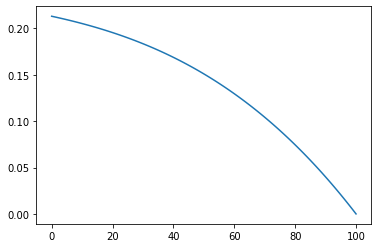

In [10]:
alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = [0.5,0.5,0.5,0.5,0.5,1.2,1.2,300, 0.3]
xinit = nmp_list_tcf[23][0]
yinit = nmp_list_tcf[23][1]
tcf_init = nmp_list_tcf[23][2]
tcf_group = nmp_list_tcf[23][3]
em_cle_tcf_alpha1_test(1, xinit, yinit, tolerance, dt , T, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, tcf_init = tcf_init, tcf_group = tcf_group)


# MCMC functions

In [11]:
# Import data

def logposterior(theta):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta)



In [12]:
def loglikelihood(theta):
    alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = theta
    
    batch_nmp_num = stoch_model_tcf(alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val)
    md = np.mean(batch_nmp_num, axis = 0)
    return -0.5*np.sum((((md - data)/0.25)**2)[0])



In [13]:
# Add evidence of activation or repression
def logprior(theta):
    alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = theta
    if 0 < alpha2 < 1  and \
       0  < a < 1  and \
       0 < c <1  and \
       0  < b < 1  and \
       0  < d < 1  and \
       0 < lambda1 < 5 and \
       0  < lambda2 < 5  and \
       0.1  < omega < 1000  and \
       0 < exit_nmp_val < 0.6:
        lp = 0.
    else:
        lp = -np.inf
    return lp


In [14]:
?np.random.normal()

Object `np.random.normal()` not found.


In [38]:
Nens = 100
# Initial (Nens) points
alpha2_ini = np.random.normal(0.5,0.05,Nens)
a_ini =  np.random.normal(0.5,0.05,Nens)
c_ini =  np.random.normal(0.5,0.05,Nens) 
b_ini =  np.random.normal(0.5,0.05,Nens)
d_ini =  np.random.normal(0.5,0.05,Nens)
lambda1_ini =  np.random.normal(1.5,0.1,Nens)
lambda2_ini = np.random.normal(1.5,0.1,Nens)
omega_ini = np.random.normal(500,10,Nens) 
exit_nmp_val_ini = np.random.normal(0.3,0.05, Nens) 

inisamples = np.array([alpha2_ini, a_ini, \
                       c_ini, b_ini, d_ini,\
                       lambda1_ini, lambda2_ini, omega_ini,\
                       exit_nmp_val_ini]).T

nwalkers, ndim = inisamples.shape
ndims = inisamples.shape[1] 
Nburnin = 0   
Nsamples = 2
dsigma = 0.25
argslist = (dsigma, sim_stages)




In [42]:
filename = "files/14.04_nonauto_stretchmove2.0.h5"
backend = emcee.backends.HDFBackend(filename)

In [49]:
with Pool() as pool:
    start = time.time()
    sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, pool = pool, moves = emcee.moves.StretchMove(a=1.3), backend = backend)
    sampler.run_mcmc(inisamples, Nsamples+Nburnin, progress=True)
    end = time.time()
    time_taken = end - start
    print("One run took {0:.1f} seconds".format(time_taken))
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))


100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.19s/it]

One run took 23.4 seconds


In [50]:
sampler.get_chain().shape

(4, 100, 9)

In [25]:
sampler.acceptance_fraction

array([0.21, 0.4 , 0.15, 0.3 , 0.2 , 0.33, 0.31, 0.22, 0.21, 0.27, 0.28,
       0.11, 0.23, 0.38, 0.2 , 0.24, 0.3 , 0.19, 0.2 , 0.31, 0.25, 0.34,
       0.28, 0.26, 0.14, 0.25, 0.42, 0.29, 0.28, 0.34, 0.29, 0.14, 0.21,
       0.25, 0.27, 0.11, 0.28, 0.14, 0.29, 0.27, 0.15, 0.16, 0.25, 0.3 ,
       0.26, 0.3 , 0.21, 0.3 , 0.24, 0.2 , 0.29, 0.22, 0.31, 0.28, 0.28,
       0.22, 0.21, 0.21, 0.22, 0.28, 0.23, 0.1 , 0.29, 0.28, 0.29, 0.28,
       0.24, 0.2 , 0.2 , 0.26, 0.21, 0.3 , 0.28, 0.18, 0.27, 0.24, 0.22,
       0.29, 0.19, 0.35, 0.2 , 0.26, 0.26, 0.23, 0.26, 0.16, 0.32, 0.21,
       0.26, 0.26, 0.24, 0.35, 0.09, 0.32, 0.37, 0.24, 0.16, 0.26, 0.27,
       0.25])

IndexError: index 9 is out of bounds for axis 0 with size 9

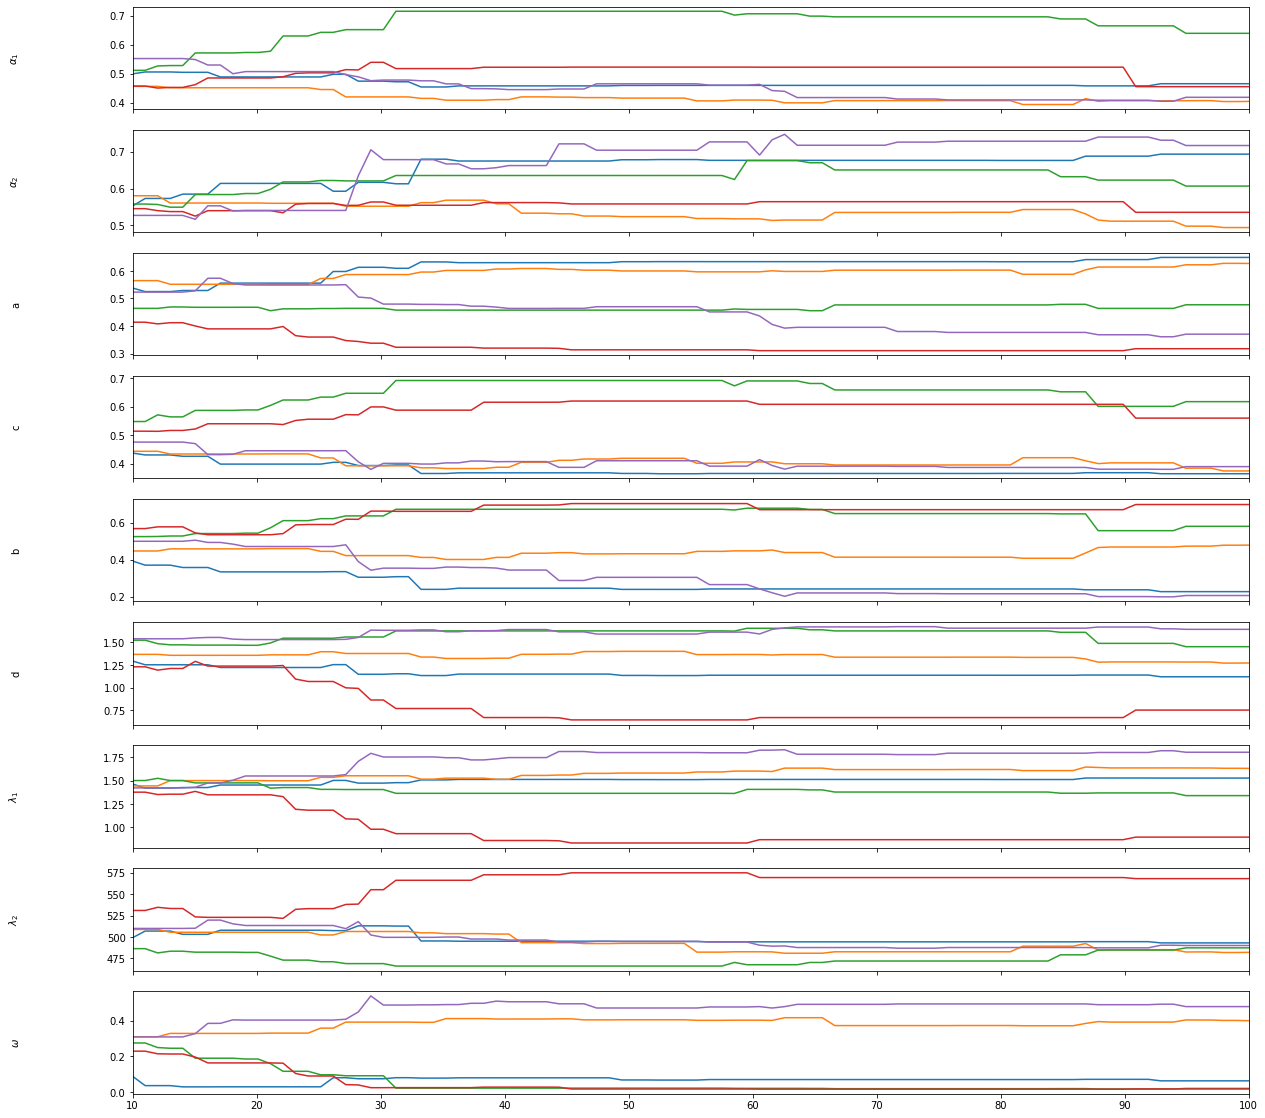

In [35]:
fig, axes = plt.subplots(9, figsize=(20,20), sharex=True)
burn_in = 10
flat = 1
labels = [r"$\alpha_1$", r"$\alpha_2$", "a", "c", "b", "d", r"$\lambda_1$", r"$\lambda_2$", r"$\omega$", "exit_val"]
x = np.linspace(burn_in, samples_grouped.shape[0], samples_grouped.shape[0]-burn_in)

samples_grouped = sampler.get_chain()

for i in range(samples_grouped.shape[1]):
    ax = axes[i]
    ax.plot(x , (samples_grouped[burn_in:,15:20, i])[0:samples_grouped.shape[0]:flat])
    ax.set_xlim(burn_in, samples_grouped.shape[0])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
samples = sampler.get_chain(flat= True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\alpha_1$")
plt.ylabel(r"$p(\alpha_1)$")
plt.gca().set_yticks([]);


In [44]:
samples_grouped.shape

(100, 100, 9)

In [34]:
samples = sampler.flatchain
fitted_params = samples[np.argmax(sampler.flatlnprobability)]

In [35]:
sampler.get_chain()

array([[[4.63604208e-01, 3.63612125e-01, 4.64532420e-01, ...,
         4.05033200e+00, 9.06994274e+02, 3.99650125e-01],
        [5.83014739e-01, 1.44946075e-01, 4.20131930e-01, ...,
         3.20077784e+00, 2.09300020e+01, 2.70277241e-01],
        [6.78723151e-01, 2.23278360e-01, 4.42054173e-01, ...,
         2.25356877e+00, 6.23020726e+02, 1.55934657e-01],
        ...,
        [6.14292192e-01, 6.52642633e-01, 2.68666499e-01, ...,
         4.47722517e+00, 2.32176924e+02, 2.19520784e-02],
        [5.06322992e-01, 4.22681122e-01, 1.96228979e-01, ...,
         4.43965738e-01, 1.73673285e+02, 1.05326773e-01],
        [2.89970531e-01, 3.83680556e-01, 4.89148527e-01, ...,
         2.18783577e+00, 3.29077520e+02, 2.51833631e-01]],

       [[4.63604208e-01, 3.63612125e-01, 4.64532420e-01, ...,
         4.05033200e+00, 9.06994274e+02, 3.99650125e-01],
        [5.83014739e-01, 1.44946075e-01, 4.20131930e-01, ...,
         3.20077784e+00, 2.09300020e+01, 2.70277241e-01],
        [6.78723151e-01, 

In [36]:
alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = fitted_params

In [37]:
d

0.5403050060565044

In [29]:
acceptance_fraction = sampler.acceptance_fraction
print('acceptance_fraction')
print((acceptance_fraction))

print(np.mean(acceptance_fraction))
print(type(acceptance_fraction))

acceptance_fraction
[0.21 0.4  0.15 0.3  0.2  0.33 0.31 0.22 0.21 0.27 0.28 0.11 0.23 0.38
 0.2  0.24 0.3  0.19 0.2  0.31 0.25 0.34 0.28 0.26 0.14 0.25 0.42 0.29
 0.28 0.34 0.29 0.14 0.21 0.25 0.27 0.11 0.28 0.14 0.29 0.27 0.15 0.16
 0.25 0.3  0.26 0.3  0.21 0.3  0.24 0.2  0.29 0.22 0.31 0.28 0.28 0.22
 0.21 0.21 0.22 0.28 0.23 0.1  0.29 0.28 0.29 0.28 0.24 0.2  0.2  0.26
 0.21 0.3  0.28 0.18 0.27 0.24 0.22 0.29 0.19 0.35 0.2  0.26 0.26 0.23
 0.26 0.16 0.32 0.21 0.26 0.26 0.24 0.35 0.09 0.32 0.37 0.24 0.16 0.26
 0.27 0.25]
0.24900000000000003
<class 'numpy.ndarray'>


In [30]:
autocorr_time = sampler.get_autocorr_time(quiet=True)
print('autocorr_time')
print(autocorr_time.shape)
print(type(autocorr_time))

N/50 = 2;
tau: [11.47031291 11.25968173 11.17478282 10.60705085 11.37099604 10.97597793
 11.33061027 11.18912949 10.28364783]


autocorr_time
(9,)
<class 'numpy.ndarray'>


In [31]:
batch_num = 0
batch = 1
batch_nmp_num = [[] for i in range(batch)]
#alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = [0.5,0.5,0.5,0.5,0.5,1.2,1.2,300, 0.3]

while batch_num < batch:
    trajs_list = []
    i = 0
    while i < nmp_numbers:
        xinit = nmp_list_tcf[i][0]
        yinit = nmp_list_tcf[i][1]
        tcf_init = nmp_list_tcf[i][2]
        #print(tcf_init)
        tcf_group = nmp_list_tcf[i][3]
        single_cell_sim = em_cle_tcf_alpha1(1, xinit, yinit, tolerance, dt , T, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, tcf_init = tcf_init, tcf_group = tcf_group, seed = batch_num)
        trajs_list.append(single_cell_sim)
        i+=1
    #print("Embryo simulation complete: {} cells".format(nmp_numbers))

    num_nmps_time = []
    for i in range(num_ss) :
        nmp_counter = 0
        traj = np.squeeze(np.array(trajs_list))[:,:,sim_stages[i]]
        for cell in traj:
            if not ((cell[0] <= exit_nmp_val and cell[1] >= exit_nmp_val) or (cell[0] >= exit_nmp_val and cell[1] <= exit_nmp_val)):
                nmp_counter += 1
        num_nmps_time.append(nmp_counter)
    #print("num_nmps_time", num_nmps_time)
    batch_nmp_num[batch_num].append(num_nmps_time)
    batch_num +=1

batch_nmp_num

[[[149,
   140,
   103,
   92,
   82,
   65,
   37,
   30,
   28,
   35,
   30,
   19,
   21,
   22,
   20,
   23,
   20,
   16,
   14,
   15,
   9,
   7,
   6,
   5,
   4,
   3,
   3,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]]]

In [41]:
sampler.get_chain(flat=True).shape

(10000, 9)

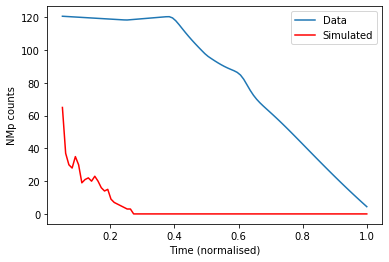

In [32]:
x = np.linspace(0,1,100)
plt.plot(x[5:100],data[5:100],label="Data")
plt.plot(x[5:100],(num_nmps_time)[5:100],label="Simulated", color = 'r')
plt.xlabel('Time (normalised)')
plt.ylabel('NMp counts')
plt.legend()

# Saving

In [32]:
samples_raw = sampler.get_chain()
print("samples : raw")
print(samples_raw.shape)
print(type(samples_raw))
print(' ')
with open("test/samples_raw_emcee.txt", "wb") as fp:   #Pickling
    pickle.dump(samples_raw, fp)



samples : raw
(100, 100, 9)
<class 'numpy.ndarray'>
 
